In [1]:
!pip install torch torchvision torchaudio
!pip install segmentation-models-pytorch==0.3.3
!pip install albumentations==1.3.0
!pip install opencv-python
!pip install matplotlib
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import os
import numpy as np
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from datasets import load_dataset

In [3]:
dataset = load_dataset("kowndinya23/Kvasir-SEG")

print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/497 [00:00<?, ?B/s]

(…)-00000-of-00001-7a33e3aba9046bad.parquet:   0%|          | 0.00/36.7M [00:00<?, ?B/s]

(…)-00000-of-00001-4d65c2d2950bdc96.parquet:   0%|          | 0.00/8.00M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/880 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/120 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['name', 'image', 'annotation'],
        num_rows: 880
    })
    validation: Dataset({
        features: ['name', 'image', 'annotation'],
        num_rows: 120
    })
})


In [12]:
# Step 3 — PyTorch Dataset Wrapper
# ===============================
class HFDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = np.array(self.dataset[idx]["image"])
        mask = np.array(self.dataset[idx]["annotation"])
        mask = (mask > 0).astype(np.float32)  # binary mask, float32

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image'].float() / 255.0  # convert to [0,1] float
            mask = augmented['mask'].float()            # already 0/1 float

        return image, mask.unsqueeze(0)


In [13]:
# ===============================
# Step 4 — Data Augmentation
# ===============================
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

In [14]:
# Step 5 — Create DataLoaders
# ===============================
train_dataset = HFDataset(dataset['train'], transform=train_transform)
val_dataset = HFDataset(dataset['validation'], transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

In [15]:
# Step 6 — Model, Loss, Optimizer
# ===============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet(
    encoder_name="resnet34",        # backbone
    encoder_weights="imagenet",     # pretrained encoder
    in_channels=3,
    classes=1,                      # binary segmentation
    activation=None
).to(DEVICE)

loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:

# ===============================
# Step 7 — Training & Evaluation
# ===============================
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    epoch_loss = 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def eval_one_epoch(model, loader, loss_fn):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)
            loss = loss_fn(preds, masks)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [17]:

# ===============================
# Step 8 — Training Loop
# ===============================
EPOCHS = 20
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
    val_loss = eval_one_epoch(model, val_loader, loss_fn)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "unet_kvasir_best.pth")

    print(f"Epoch {epoch+1}/{EPOCHS} — Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

print("✅ Training complete. Best model saved as unet_kvasir_best.pth")

Epoch 1/20 — Train Loss: 0.5469 | Val Loss: 0.4781
Epoch 2/20 — Train Loss: 0.4047 | Val Loss: 0.3804
Epoch 3/20 — Train Loss: 0.3266 | Val Loss: 0.3195
Epoch 4/20 — Train Loss: 0.2741 | Val Loss: 0.2577
Epoch 5/20 — Train Loss: 0.2260 | Val Loss: 0.2148
Epoch 6/20 — Train Loss: 0.2027 | Val Loss: 0.2128
Epoch 7/20 — Train Loss: 0.1760 | Val Loss: 0.1906
Epoch 8/20 — Train Loss: 0.1573 | Val Loss: 0.1940
Epoch 9/20 — Train Loss: 0.1337 | Val Loss: 0.1885
Epoch 10/20 — Train Loss: 0.1375 | Val Loss: 0.1674
Epoch 11/20 — Train Loss: 0.1296 | Val Loss: 0.2313
Epoch 12/20 — Train Loss: 0.1273 | Val Loss: 0.1729
Epoch 13/20 — Train Loss: 0.1104 | Val Loss: 0.1880
Epoch 14/20 — Train Loss: 0.1329 | Val Loss: 0.2090
Epoch 15/20 — Train Loss: 0.1155 | Val Loss: 0.1668
Epoch 16/20 — Train Loss: 0.1075 | Val Loss: 0.1536
Epoch 17/20 — Train Loss: 0.1209 | Val Loss: 0.1699
Epoch 18/20 — Train Loss: 0.1193 | Val Loss: 0.1710
Epoch 19/20 — Train Loss: 0.1037 | Val Loss: 0.1642
Epoch 20/20 — Train L

In [18]:
# import os
# import numpy as np
# import torch
# import cv2
# from torch.utils.data import Dataset, DataLoader
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# import segmentation_models_pytorch as smp
# from datasets import load_dataset

# ===============================
# Load Dataset
# ===============================
dataset = load_dataset("kowndinya23/Kvasir-SEG")

class HFDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = np.array(self.dataset[idx]["image"])
        mask = np.array(self.dataset[idx]["annotation"])
        mask = (mask > 0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image'].float() / 255.0  # normalize
            mask = augmented['mask'].float()

        return image, mask.unsqueeze(0)

# ===============================
# Data Augmentation
# ===============================
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

train_dataset = HFDataset(dataset['train'], transform=train_transform)
val_dataset = HFDataset(dataset['validation'], transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# ===============================
# Model, Loss, Optimizer
# ===============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(DEVICE)

loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Metrics
def dice_coeff(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    return (2. * intersection) / (preds.sum() + targets.sum() + 1e-7)

def iou_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return intersection / (union + 1e-7)

# ===============================
# Training & Evaluation
# ===============================
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    epoch_loss, epoch_dice, epoch_iou = 0, 0, 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_dice += dice_coeff(preds, masks).item()
        epoch_iou += iou_score(preds, masks).item()

    return (epoch_loss / len(loader),
            epoch_dice / len(loader),
            epoch_iou / len(loader))

def eval_one_epoch(model, loader, loss_fn):
    model.eval()
    epoch_loss, epoch_dice, epoch_iou = 0, 0, 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)
            loss = loss_fn(preds, masks)

            epoch_loss += loss.item()
            epoch_dice += dice_coeff(preds, masks).item()
            epoch_iou += iou_score(preds, masks).item()

    return (epoch_loss / len(loader),
            epoch_dice / len(loader),
            epoch_iou / len(loader))

# ===============================
# Training Loop with Early Stopping
# ===============================
EPOCHS = 50
best_val_loss = float('inf')
patience_counter = 0
early_stop_patience = 7  # stop if no improvement for 7 epochs

for epoch in range(EPOCHS):
    train_loss, train_dice, train_iou = train_one_epoch(model, train_loader, optimizer, loss_fn)
    val_loss, val_dice, val_iou = eval_one_epoch(model, val_loader, loss_fn)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f} || "
          f"Val Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "unet_kvasir_best.pth")
        patience_counter = 0
        print("✅ Saved new best model.")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("⏹ Early stopping triggered.")
            break

print("🎯 Training complete. Best model saved as unet_kvasir_best.pth")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Train Loss: 0.5617 | Dice: 0.6658 | IoU: 0.5158 || Val Loss: 0.4959 | Dice: 0.7386 | IoU: 0.5906
✅ Saved new best model.
Epoch 2/50 | Train Loss: 0.4275 | Dice: 0.7696 | IoU: 0.6346 || Val Loss: 0.3924 | Dice: 0.7870 | IoU: 0.6540
✅ Saved new best model.
Epoch 3/50 | Train Loss: 0.3446 | Dice: 0.8151 | IoU: 0.6934 || Val Loss: 0.3310 | Dice: 0.8259 | IoU: 0.7078
✅ Saved new best model.
Epoch 4/50 | Train Loss: 0.2711 | Dice: 0.8419 | IoU: 0.7330 || Val Loss: 0.2753 | Dice: 0.8098 | IoU: 0.6829
✅ Saved new best model.
Epoch 5/50 | Train Loss: 0.2244 | Dice: 0.8555 | IoU: 0.7515 || Val Loss: 0.2414 | Dice: 0.8151 | IoU: 0.6936
✅ Saved new best model.
Epoch 6/50 | Train Loss: 0.1962 | Dice: 0.8600 | IoU: 0.7594 || Val Loss: 0.2450 | Dice: 0.7965 | IoU: 0.6688
Epoch 7/50 | Train Loss: 0.1798 | Dice: 0.8615 | IoU: 0.7611 || Val Loss: 0.2117 | Dice: 0.8195 | IoU: 0.7022
✅ Saved new best model.
Epoch 8/50 | Train Loss: 0.1592 | Dice: 0.8708 | IoU: 0.7766 || Val Loss: 0.2016 | Dic

Epoch 1/50 | Train Loss: 0.5033 | Dice: 0.6562 | IoU: 0.5064 || Val Loss: 0.3940 | Dice: 0.7593 | IoU: 0.6152
✅ Saved new best model.
Epoch 2/50 | Train Loss: 0.3252 | Dice: 0.7917 | IoU: 0.6617 || Val Loss: 0.3062 | Dice: 0.7978 | IoU: 0.6689
✅ Saved new best model.
Epoch 3/50 | Train Loss: 0.2443 | Dice: 0.8362 | IoU: 0.7233 || Val Loss: 0.3022 | Dice: 0.7634 | IoU: 0.6202
✅ Saved new best model.
Epoch 4/50 | Train Loss: 0.2101 | Dice: 0.8455 | IoU: 0.7375 || Val Loss: 0.2744 | Dice: 0.7671 | IoU: 0.6295
✅ Saved new best model.
Epoch 5/50 | Train Loss: 0.1853 | Dice: 0.8515 | IoU: 0.7482 || Val Loss: 0.2234 | Dice: 0.8069 | IoU: 0.6827
✅ Saved new best model.
Epoch 6/50 | Train Loss: 0.1621 | Dice: 0.8658 | IoU: 0.7682 || Val Loss: 0.2367 | Dice: 0.7846 | IoU: 0.6520
Epoch 7/50 | Train Loss: 0.1634 | Dice: 0.8567 | IoU: 0.7556 || Val Loss: 0.1939 | Dice: 0.8216 | IoU: 0.7003
✅ Saved new best model.
Epoch 8/50 | Train Loss: 0.1371 | Dice: 0.8797 | IoU: 0.7888 || Val Loss: 0.2002 | Dic

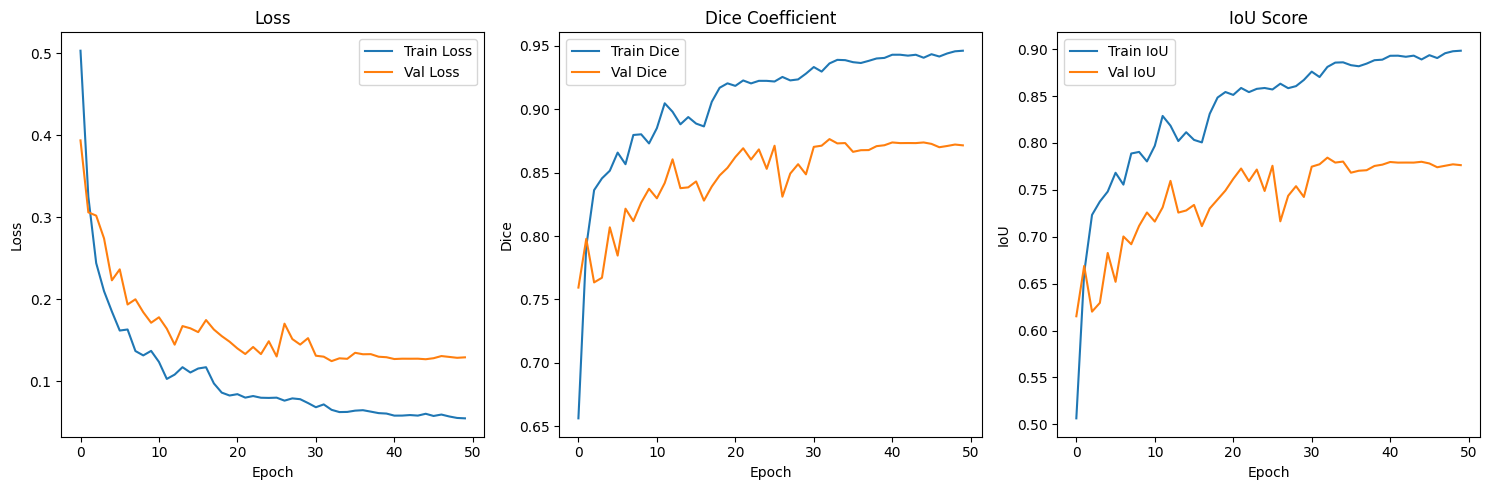

In [21]:
import os
import numpy as np
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from datasets import load_dataset
import matplotlib.pyplot as plt

# ===============================
# Load Dataset
# ===============================
dataset = load_dataset("kowndinya23/Kvasir-SEG")

class HFDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = np.array(self.dataset[idx]["image"])
        mask = np.array(self.dataset[idx]["annotation"])
        mask = (mask > 0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image'].float() / 255.0  # normalize to [0,1]
            mask = augmented['mask'].float()

        return image, mask.unsqueeze(0)

# ===============================
# Data Augmentation
# ===============================
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

train_dataset = HFDataset(dataset['train'], transform=train_transform)
val_dataset = HFDataset(dataset['validation'], transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# ===============================
# Model, Loss, Optimizer
# ===============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(DEVICE)

loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# ===============================
# Metrics
# ===============================
def dice_coeff(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    return (2. * intersection) / (preds.sum() + targets.sum() + 1e-7)

def iou_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return intersection / (union + 1e-7)

# ===============================
# Training & Evaluation Functions
# ===============================
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    epoch_loss, epoch_dice, epoch_iou = 0, 0, 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_dice += dice_coeff(preds, masks).item()
        epoch_iou += iou_score(preds, masks).item()

    return (epoch_loss / len(loader),
            epoch_dice / len(loader),
            epoch_iou / len(loader))

def eval_one_epoch(model, loader, loss_fn):
    model.eval()
    epoch_loss, epoch_dice, epoch_iou = 0, 0, 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            preds = model(imgs)
            loss = loss_fn(preds, masks)

            epoch_loss += loss.item()
            epoch_dice += dice_coeff(preds, masks).item()
            epoch_iou += iou_score(preds, masks).item()

    return (epoch_loss / len(loader),
            epoch_dice / len(loader),
            epoch_iou / len(loader))

# ===============================
# Training Loop (No Early Stopping)
# ===============================
EPOCHS = 50
best_val_loss = float('inf')

history = {
    "train_loss": [], "val_loss": [],
    "train_dice": [], "val_dice": [],
    "train_iou": [], "val_iou": []
}

for epoch in range(EPOCHS):
    train_loss, train_dice, train_iou = train_one_epoch(model, train_loader, optimizer, loss_fn)
    val_loss, val_dice, val_iou = eval_one_epoch(model, val_loader, loss_fn)

    scheduler.step(val_loss)

    # Save metrics
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_dice"].append(train_dice)
    history["val_dice"].append(val_dice)
    history["train_iou"].append(train_iou)
    history["val_iou"].append(val_iou)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f} || "
          f"Val Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "unet_kvasir_best.pth")
        print("✅ Saved new best model.")

print("🎯 Training complete. Best model saved as unet_kvasir_best.pth")

# ===============================
# Plotting
# ===============================
plt.figure(figsize=(15,5))

# Loss
plt.subplot(1,3,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Dice
plt.subplot(1,3,2)
plt.plot(history["train_dice"], label="Train Dice")
plt.plot(history["val_dice"], label="Val Dice")
plt.title("Dice Coefficient")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()

# IoU
plt.subplot(1,3,3)
plt.plot(history["train_iou"], label="Train IoU")
plt.plot(history["val_iou"], label="Val IoU")
plt.title("IoU Score")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
# Load the best model
model.load_state_dict(torch.load("unet_kvasir_best.pth", map_location=DEVICE))
model.eval()
print("✅ Best model loaded successfully.")


✅ Best model loaded successfully.


In [23]:
val_loss, val_dice, val_iou = eval_one_epoch(model, val_loader, loss_fn)
print(f"📊 Final Validation Results — Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")


📊 Final Validation Results — Loss: 0.1248, Dice: 0.8765, IoU: 0.7843


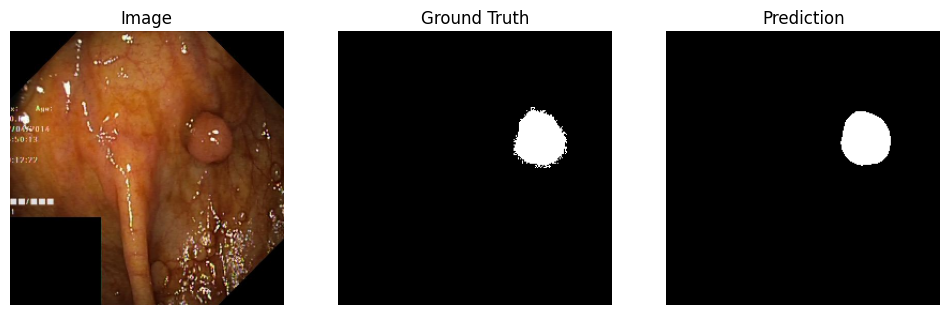

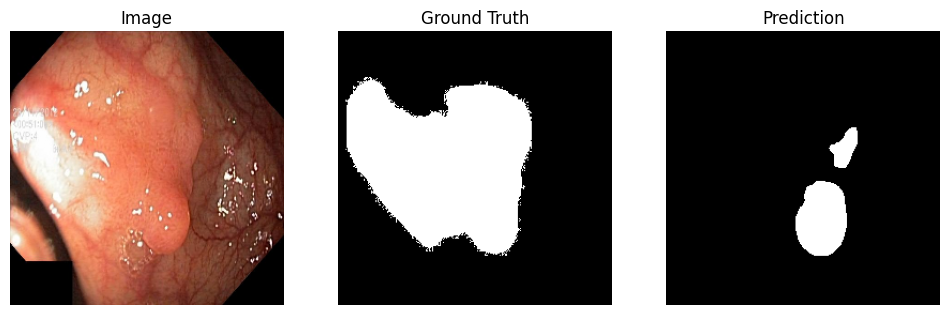

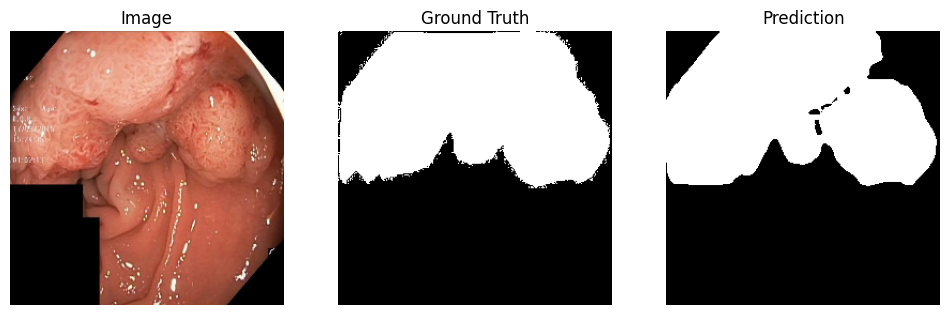

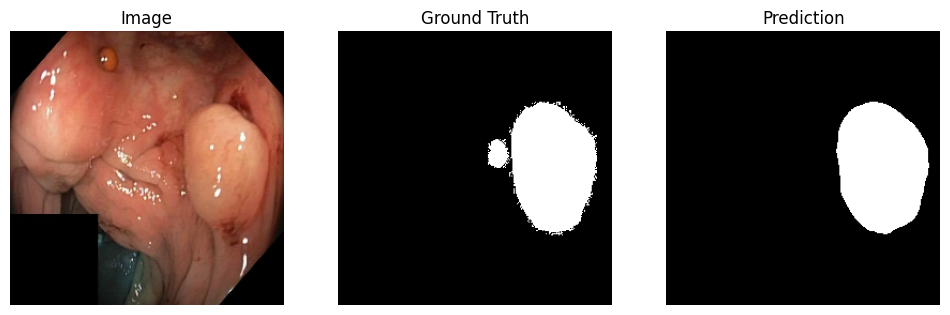

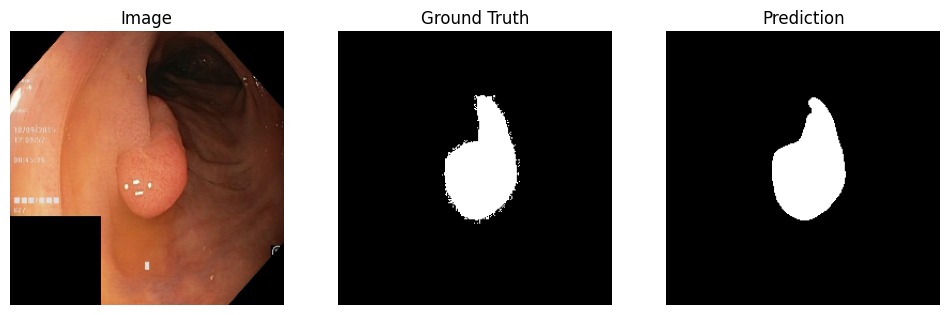

In [24]:
import matplotlib.pyplot as plt

def visualize_predictions(model, loader, num_samples=3):
    model.eval()
    images, masks, preds = [], [], []
    with torch.no_grad():
        for imgs, true_masks in loader:
            imgs = imgs.to(DEVICE)
            outputs = torch.sigmoid(model(imgs))
            outputs = (outputs > 0.5).float()
            images.extend(imgs.cpu())
            masks.extend(true_masks.cpu())
            preds.extend(outputs.cpu())
            if len(images) >= num_samples:
                break

    for i in range(num_samples):
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(images[i].permute(1, 2, 0))
        ax[0].set_title("Image")
        ax[0].axis("off")

        ax[1].imshow(masks[i][0], cmap="gray")
        ax[1].set_title("Ground Truth")
        ax[1].axis("off")

        ax[2].imshow(preds[i][0], cmap="gray")
        ax[2].set_title("Prediction")
        ax[2].axis("off")

        plt.show()

visualize_predictions(model, val_loader, num_samples=5)


In [25]:
import os
import matplotlib.pyplot as plt

def save_all_predictions(model, loader, save_dir="val_predictions"):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    idx = 0

    with torch.no_grad():
        for imgs, true_masks in loader:
            imgs = imgs.to(DEVICE)
            outputs = torch.sigmoid(model(imgs))
            outputs = (outputs > 0.5).float()

            for i in range(imgs.size(0)):
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))

                # Image
                ax[0].imshow(imgs[i].cpu().permute(1, 2, 0))
                ax[0].set_title("Image")
                ax[0].axis("off")

                # Ground Truth
                ax[1].imshow(true_masks[i][0].cpu(), cmap="gray")
                ax[1].set_title("Ground Truth")
                ax[1].axis("off")

                # Prediction
                ax[2].imshow(outputs[i][0].cpu(), cmap="gray")
                ax[2].set_title("Prediction")
                ax[2].axis("off")

                # Save the figure
                save_path = os.path.join(save_dir, f"val_pred_{idx:04d}.png")
                plt.savefig(save_path, bbox_inches="tight")
                plt.close(fig)
                idx += 1

    print(f"✅ Saved {idx} prediction comparisons to '{save_dir}'")

# Run it after training
save_all_predictions(model, val_loader, save_dir="val_predictions")


✅ Saved 120 prediction comparisons to 'val_predictions'


In [28]:
!pip install onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 113.5 MB/s eta 0:00:00


In [29]:
!pip install onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.5 MB/s eta 0:00:00


In [30]:
# TorchScript using tracing instead of scripting
example_input = torch.randn(1, 3, 256, 256).to(DEVICE)
traced_model = torch.jit.trace(model, example_input)
traced_model.save("unet_kvasir_traced.pt")
print("✅ TorchScript model saved as unet_kvasir_traced.pt")

# ONNX export
torch.onnx.export(
    model,
    example_input,
    "unet_kvasir.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)
print("✅ ONNX model saved as unet_kvasir.onnx")


✅ TorchScript model saved as unet_kvasir_traced.pt
✅ ONNX model saved as unet_kvasir.onnx


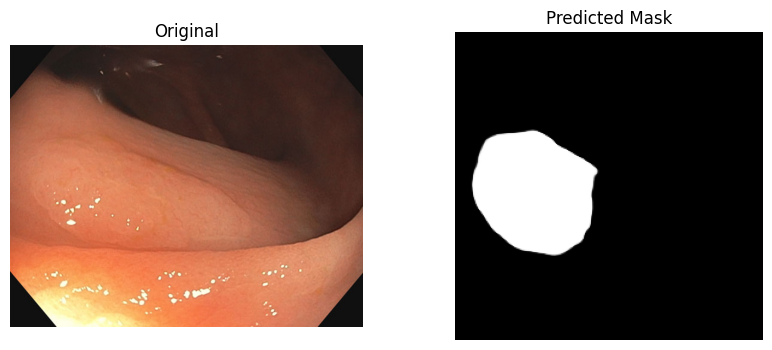

In [35]:
from PIL import Image


def predict_single_image(model, image_path):
    model.eval()
    img = np.array(Image.open(image_path).convert("RGB"))
    transform = A.Compose([
        A.Resize(256, 256),
        ToTensorV2()
    ])
    augmented = transform(image=img)
    img_tensor = augmented['image'].float().unsqueeze(0).to(DEVICE) / 255.0

    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor))[0, 0].cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Example:
predict_single_image(model, "flat-colonic-polyp.jpg")


Evaluating: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]



📊 Final Validation Metrics
Dice Coefficient: 0.8765
IoU Score:        0.7844
Precision:        0.9038
Recall:           0.8570
Specificity:      0.9832
ROC-AUC:          0.9418


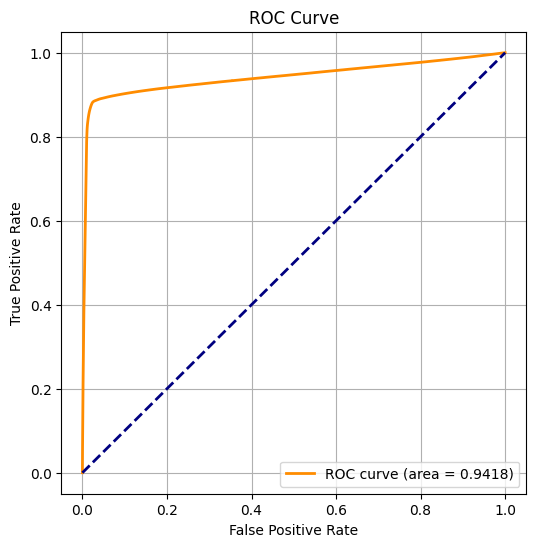

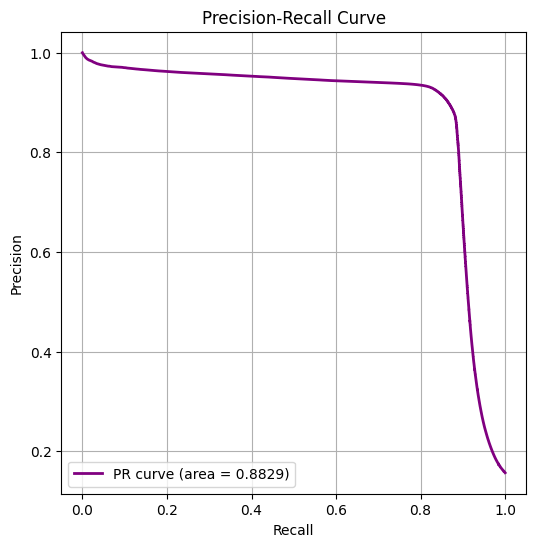

In [36]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==============================
# Metric Functions
# ==============================
def dice_coeff(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    return (2. * intersection) / (preds.sum() + targets.sum() + 1e-7)

def iou_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return intersection / (union + 1e-7)

def precision_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    tp = (preds * targets).sum()
    fp = (preds * (1 - targets)).sum()
    return tp / (tp + fp + 1e-7)

def recall_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    tp = (preds * targets).sum()
    fn = ((1 - preds) * targets).sum()
    return tp / (tp + fn + 1e-7)

def specificity_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    tn = ((1 - preds) * (1 - targets)).sum()
    fp = (preds * (1 - targets)).sum()
    return tn / (tn + fp + 1e-7)

# ==============================
# Evaluation Loop
# ==============================
model.eval()
dice_list, iou_list, prec_list, rec_list, spec_list = [], [], [], [], []
all_targets, all_preds = [], []

with torch.no_grad():
    for imgs, masks in tqdm(val_loader, desc="Evaluating"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        outputs = model(imgs)
        outputs_sigmoid = torch.sigmoid(outputs)

        dice_list.append(dice_coeff(outputs_sigmoid, masks).item())
        iou_list.append(iou_score(outputs_sigmoid, masks).item())
        prec_list.append(precision_score(outputs_sigmoid, masks).item())
        rec_list.append(recall_score(outputs_sigmoid, masks).item())
        spec_list.append(specificity_score(outputs_sigmoid, masks).item())

        all_preds.extend(outputs_sigmoid.cpu().numpy().flatten())
        all_targets.extend(masks.cpu().numpy().flatten())

# ==============================
# Compute ROC-AUC
# ==============================
roc_auc = roc_auc_score(all_targets, all_preds)

print("\n📊 Final Validation Metrics")
print(f"Dice Coefficient: {np.mean(dice_list):.4f}")
print(f"IoU Score:        {np.mean(iou_list):.4f}")
print(f"Precision:        {np.mean(prec_list):.4f}")
print(f"Recall:           {np.mean(rec_list):.4f}")
print(f"Specificity:      {np.mean(spec_list):.4f}")
print(f"ROC-AUC:          {roc_auc:.4f}")

# ==============================
# Plot ROC Curve
# ==============================
fpr, tpr, _ = roc_curve(all_targets, all_preds)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("roc_curve.png")
plt.show()

# ==============================
# Plot Precision-Recall Curve
# ==============================
precision_vals, recall_vals, _ = precision_recall_curve(all_targets, all_preds)
pr_auc_val = auc(recall_vals, precision_vals)

plt.figure(figsize=(6, 6))
plt.plot(recall_vals, precision_vals, color='purple', lw=2, label=f'PR curve (area = {pr_auc_val:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid()
plt.savefig("precision_recall_curve.png")
plt.show()


In [38]:
# Save the whole model
torch.save(model, "unet_kvasir_full.pth")
print("✅ Full model saved.")


✅ Full model saved.
